## Natural Language Processing (NLP) on yelp user reviews

Notebook showing NLP cabability in scikit-learn to predict user review star ratings based on review text. An ensemble regression model is implemented as well as investigations into models using Naive Bayes, Gradient Boosting, XGBoost and a random forest classifier. 

Also shows a method using a naive bayes model for calculating key polarizing words most likely to indicate a negative or positive review

In [19]:
import seaborn as sns
sns.set()

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn import base
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
%%time
with open('data/yelp_dataset/yelp_academic_dataset_review.json') as f:
    data = [json.loads(line) for line in f]

CPU times: user 46.7 s, sys: 8.94 s, total: 55.6 s
Wall time: 57.1 s


In [4]:
#take a sample of the data
test_data = data[len(data)//30:len(data)//30+10000] 
data = data[:len(data)//30]

In [5]:
test_data[1]

{'review_id': 'JTRB0MnLGWAQ7tnHs4jdSQ',
 'user_id': 'vqAz3Ny-sknx_KKife4xzA',
 'business_id': '2er_V-oAd7IbQ5YTY56r7A',
 'stars': 4.0,
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'text': 'While in Philly we stopped at Bareburger yesterday. Order the American Burger plus a burger with the brisket. We also ordered the tater tots and onion rings. The burger with the brisket with the Smoke Barbecue sauce was unbelievable the tater tots and onion rings were very good as well. We had no problem with the service the atmosphere was very nice. We will definitely be back. The only thing that I did not like where the sauces they gave us for the onion rings.',
 'date': '2018-01-15 16:42:22'}

In [6]:
stars = [row['stars'] for row in data]
test_stars = [row['stars'] for row in test_data]

In [26]:
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        return pd.DataFrame.from_dict(X)

In [27]:
%%time
to_data_frame = ToDataFrame()
X_t = to_data_frame.fit_transform(data)

CPU times: user 493 ms, sys: 32.1 ms, total: 525 ms
Wall time: 524 ms


In [28]:
X_t.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


<Axes: xlabel='stars', ylabel='Count'>

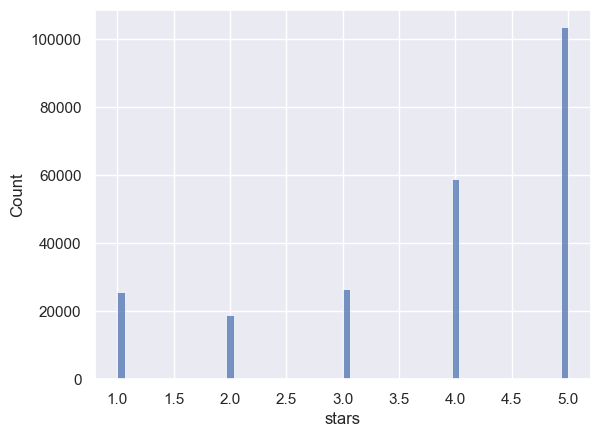

In [29]:
plt.figure()
sns.histplot(data = X_t, x='stars')

In [61]:
#words_vectorizer = CountVectorizer()#(min_df = 0.5, max_df=0.95)
words_vectorizer = TfidfVectorizer(max_features = 5000, 
                             ngram_range=(1,2), stop_words=list(STOP_WORDS))

In [81]:
text_selector = ColumnTransformer([
    ('text', words_vectorizer, 'text')#,
    #('onehot', OneHotEncoder(handle_unknown='ignore'), ['useful', 'funny', 'cool']) #adding these made the model
                                                                                     #accuracy worse
])

In [82]:
%%time
words_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', text_selector),
    ('regressor', LogisticRegression(max_iter=1000))
])

words_model.fit(data, stars)

CPU times: user 7min 5s, sys: 1min 31s, total: 8min 37s
Wall time: 2min 6s


Pipeline(steps=[('data_frame', ToDataFrame()),
                ('selector',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['somehow',
                                                                              "'m",
                                                                              'own',
                                                                              'again',
                                                                              'cannot',
                                                                              'doing',
                                                                              'for',
                                                                              'forty',
                                                                              'enough',
                                                                              'ourselves',
                                                                              'thereby',
                                                                              'whenever',
                                                                              'using',
                                                                              'fifty',
                                                                              'her',
                                                                              'thereupon',
                                                                              '’m',
                                                                              'nor',
                                                                              'side',
                                                                              'least',
                                                                              'anywhere',
                                                                              'should',
                                                                              'neither',
                                                                              'with',
                                                                              'nowhere',
                                                                              'without',
                                                                              'within',
                                                                              'there',
                                                                              'does',
                                                                              'give', ...]),
                                                  'text')])),
                ('regressor', LogisticRegression(max_iter=1000))])

In [83]:
%%time
#predictions_train = words_model.predict(data)
predictions_test = words_model.predict(test_data)

CPU times: user 1.09 s, sys: 48 ms, total: 1.14 s
Wall time: 1.03 s


In [84]:
accuracy_score(test_stars, predictions_test)

0.6463

In [88]:
%%time
cv_score = np.mean(cross_val_score(estimator = words_model, X = data, 
                                      y = stars, cv = 3, scoring = 'accuracy'))
cv_score

CPU times: user 15min 30s, sys: 4min 1s, total: 19min 31s
Wall time: 4min 37s


0.643846365920819

<Figure size 640x480 with 0 Axes>

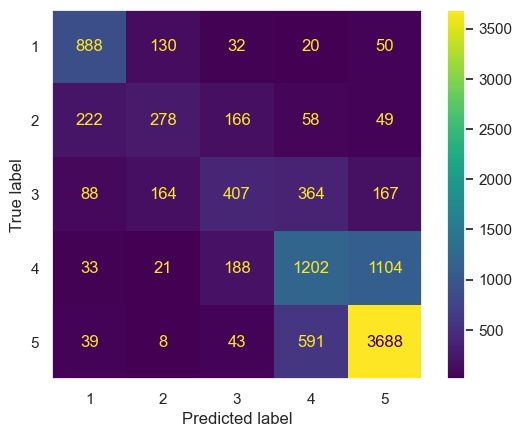

In [86]:
plt.figure()
conf = confusion_matrix(test_stars, predictions_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()

It is clear that this model has a clear bias for predicting polarized scores (1 or 5) particularly positive reviews. Lets see if I can improve anything by doing a cross validation grid search optimization

In [87]:
%%time
params={
    'regressor__C':[0.1,1.0,10.0],
    'regressor__penalty':[None,'11','12'],
    'regressor__max_iter':[100,500],
    'regressor__tol':[0.0001, 0.001]
}
grid_pipe = GridSearchCV(words_model,
                         param_grid=params,
                         cv=5,
                         verbose=1)

grid_pipe.fit(data, stars)
# Print the best parameters and the best score
print('Best parameters: ', grid_pipe.best_params_)
print('Best score: ', grid_pipe.best_score_)

y_pred = grid_pipe.predict(test_data)
accuracy = accuracy_score(test_stars, y_pred)
print('Test Accuracy: ', accuracy)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'regressor__C': 0.1, 'regressor__max_iter': 100, 'regressor__penalty': None, 'regressor__tol': 0.0001}
Best score:  0.6400697059141695
Test Accuracy:  0.6458
CPU times: user 5h 35min 55s, sys: 1h 4min 6s, total: 6h 40min 1s
Wall time: 2h 47min 50s


Unfortunately this still didnt improve the model

## Key word polarity

Define the polarity of the word as 

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{positive})}{Pr(w\ |\ \textrm{negative})}\right)$$

I want to do some exploratory analysis of which words correspond to very positive or very negative reviews

In [19]:
stars_array = np.asarray(stars)
ipolar = np.where((stars_array == 1) | (stars_array == 5))[0]
polar_stars = list(stars_array[ipolar])

In [20]:
polar_data = list(np.asarray(data)[ipolar])

In [21]:
X_polar = to_data_frame.fit_transform(polar_data)

In [22]:
polar_selector = ColumnTransformer([
    ('text', to_data_frame, 'text')])

In [23]:
polar_words_selection = polar_selector.fit_transform(X_polar)
polar_words_selection = [p[0] for p in polar_words_selection]

In [24]:
polar_vectorizer = TfidfVectorizer(max_features = 5000, stop_words=list(STOP_WORDS))

In [25]:
%%time
polar_vector = polar_vectorizer.fit_transform(polar_words_selection)

/Users/arikaplan/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


CPU times: user 7 s, sys: 96.7 ms, total: 7.1 s
Wall time: 7.1 s


In [26]:
clf = MultinomialNB()

In [27]:
clf.fit(polar_vector, polar_stars)

MultinomialNB()

In [28]:
probs = clf.feature_log_prob_

In [29]:
pol = probs[1]-probs[0]

In [30]:
isort = np.argsort(pol)

In [31]:
polar_tokens = polar_vectorizer.get_feature_names_out()

In [32]:
num = 20
positive = np.flip(polar_tokens[isort][-num:])
positive_polarity = np.flip(pol[isort][-num:])
negative = polar_tokens[isort][:num]
negative_polarity = pol[isort][:num]

Lets look at the 20 most polarizing words, i.e. words with the highest polarity score in the 1 and 5 star review texts

<Axes: >

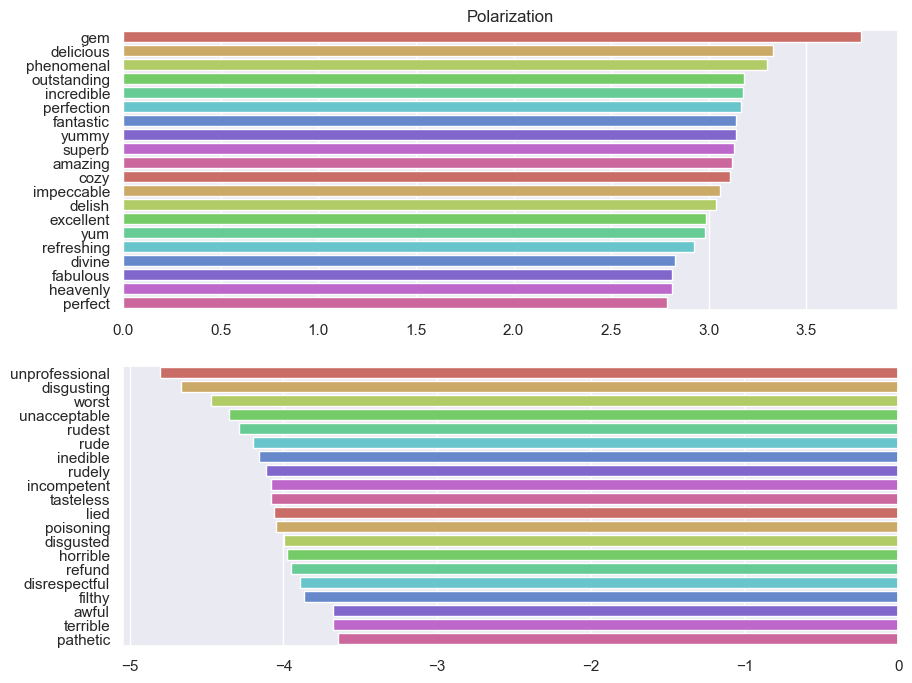

In [33]:
fig, axes = plt.subplots(2, 1, figsize = (10,8))
axes[0].set_title(f'Polarization')
#axes[1].set_title(f'Polarization')
sns.barplot(y=positive, x=positive_polarity, ax=axes[0], palette=sns.color_palette("hls", 10))
sns.barplot(y=negative, x=negative_polarity, ax=axes[1], palette=sns.color_palette("hls", 10))

Lets see how often these polarizing words show up in 1 and 5 star reviews, as well as 2-4 star reviews

In [34]:
non_polar_stars = list(stars_array[~ipolar])
non_polar_data = list(np.asarray(data)[~ipolar])

In [35]:
#count the number of polar words in a review and add as a feature
#add the number of times it shows up in a review weighted by the polarity of the word

In [36]:
%%time
positive_word_intersection = pd.Series(polar_data) \
.map(lambda x: x['text'].split(' ')) \
.map(lambda x: np.intersect1d(x, positive)) \
.explode().value_counts(dropna=True)

CPU times: user 13.4 s, sys: 248 ms, total: 13.6 s
Wall time: 13.6 s


In [37]:
%%time
negative_word_intersection = pd.Series(polar_data) \
.map(lambda x: x['text'].split(' ')) \
.map(lambda x: np.intersect1d(x, negative)) \
.explode().value_counts(dropna=True)

CPU times: user 12.7 s, sys: 230 ms, total: 12.9 s
Wall time: 13 s


Plot the frequency that the polarizing words show up in the 1 and 5 star reviews. You can see that the spread follows the pattern seen in the polarization histograms

<Axes: title={'center': 'Negative word frequency'}>

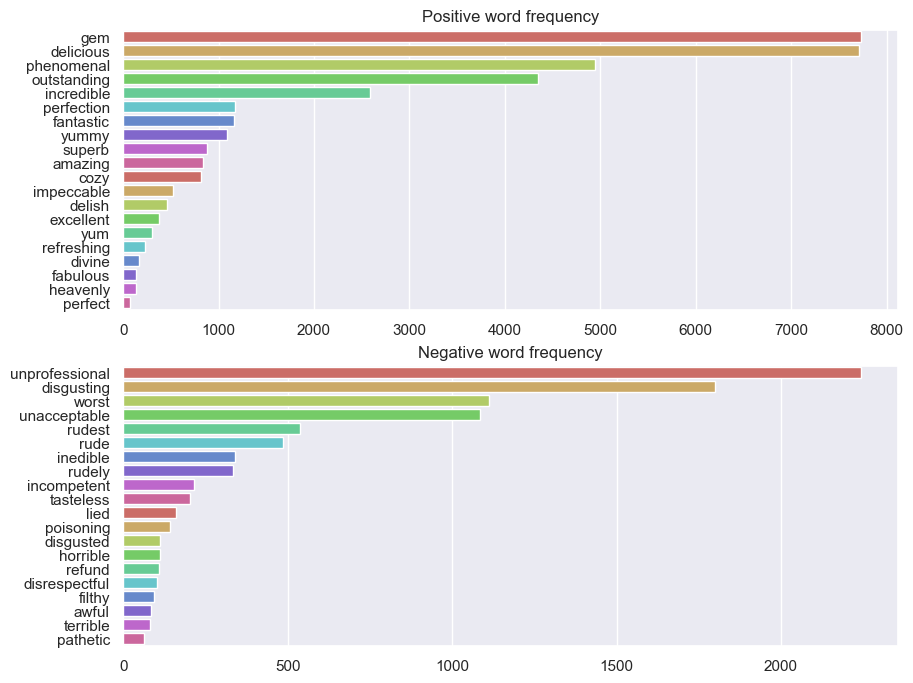

In [38]:
fig, axes = plt.subplots(2, 1, figsize = (10,8))
axes[0].set_title(f'Positive word frequency')
axes[1].set_title(f'Negative word frequency')
sns.barplot(y=positive, x=positive_word_intersection, ax=axes[0], palette=sns.color_palette("hls", 10))
sns.barplot(y=negative, x=negative_word_intersection, ax=axes[1], palette=sns.color_palette("hls", 10))

In [39]:
%%time
polar_count = pd.Series(polar_data).map(lambda x: x['text'].split(' ')).map(lambda x: len(np.intersect1d(x, positive)))
#this is to get total number of positive reviews, I also want to see how much the actual words show up

CPU times: user 13.1 s, sys: 237 ms, total: 13.3 s
Wall time: 13.4 s


In [40]:
%%time
positive_word_intersection_np = pd.Series(non_polar_data) \
.map(lambda x: x['text'].split(' ')) \
.map(lambda x: np.intersect1d(x, positive)) \
.explode().value_counts(dropna=True)

CPU times: user 14.4 s, sys: 277 ms, total: 14.6 s
Wall time: 14.7 s


In [41]:
%%time
negative_word_intersection_np = pd.Series(non_polar_data) \
.map(lambda x: x['text'].split(' ')) \
.map(lambda x: np.intersect1d(x, negative)) \
.explode().value_counts(dropna=True)

CPU times: user 14.2 s, sys: 249 ms, total: 14.4 s
Wall time: 14.4 s


Plot the frequency of polarizing words in non-polar reviews (i.e. 2-4 star reviews)

<Axes: title={'center': 'Negative word frequency'}>

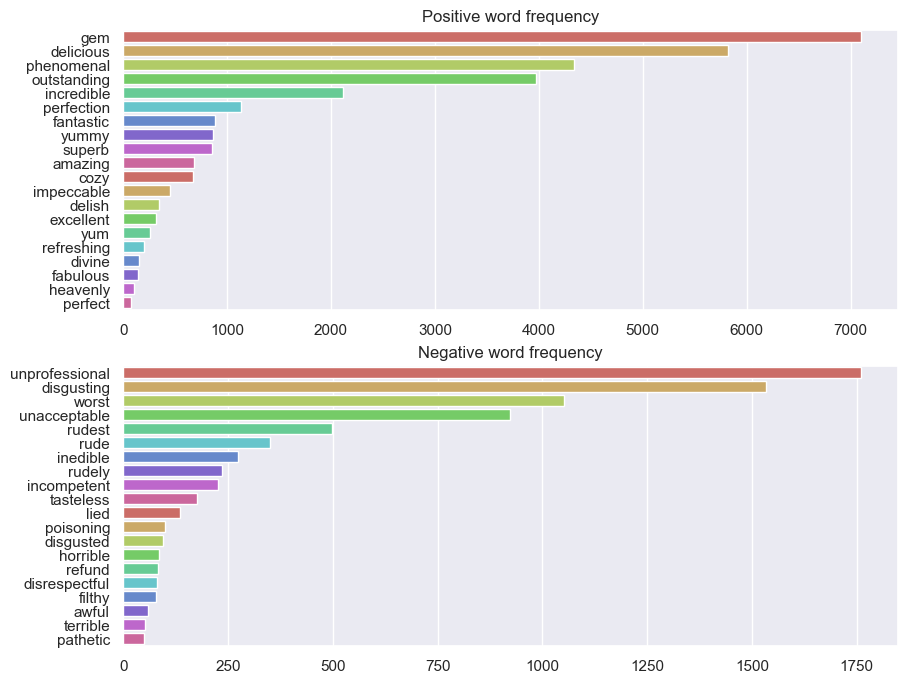

In [42]:
fig, axes = plt.subplots(2, 1, figsize = (10,8))
axes[0].set_title(f'Positive word frequency')
axes[1].set_title(f'Negative word frequency')
sns.barplot(y=positive, x=positive_word_intersection_np, ax=axes[0], palette=sns.color_palette("hls", 10))
sns.barplot(y=negative, x=negative_word_intersection_np, ax=axes[1], palette=sns.color_palette("hls", 10))

Follows the same patterns, perhaps adding polarity as a feature could help improve accuracy in predicting non-polar reviews

In [43]:
polarizations = dict(list(zip(positive, positive_polarity)) + list(zip(negative, negative_polarity)))

In [44]:
#i want to add the number of times a given polarized word shows up, scaled by its polarization

In [45]:
class addFeatures(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        X = X.copy()
        
        #sum the number of polar words that show up in a body of text, scaled by the word polarity
        polar_word_intersection = X['text'].map(lambda x: x.split(' ')) \
        .map(lambda x: np.intersect1d(x, list(polarizations.keys()))) \
        .map(lambda x: 0 if len(x) == 0 else sum([polarizations[p] for p in x])) 

        X['polarization'] = polar_word_intersection
        
        return X

In [46]:
polar_text_selector = ColumnTransformer([
    ('text', words_vectorizer, 'text'),
    ('polarization', 'passthrough', ['polarization'])
], remainder = 'drop')

In [47]:
%%time
polar_model = Pipeline([
    ('data_frame', to_data_frame),
    ('addFeatures', addFeatures()),
    ('selector', polar_text_selector),
    ('regressor', LogisticRegression(max_iter=1000))
])

polar_model.fit(data, stars)

/Users/arikaplan/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


CPU times: user 10min 6s, sys: 2min 9s, total: 12min 16s
Wall time: 3min 8s


Pipeline(steps=[('data_frame', ToDataFrame()), ('addFeatures', addFeatures()),
                ('selector',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['fifteen',
                                                                              'through',
                                                                              "'s",
                                                                              'few',
                                                                              'eleven',
                                                                              'even',
                                                                              'all',
                                                                              'doing',
                                                                              'then',
                                                                              'bottom',
                                                                              'everything',
                                                                              'using',
                                                                              'ten',
                                                                              'ours',
                                                                              'another',
                                                                              'where',
                                                                              'anyway',
                                                                              '‘s',
                                                                              'any',
                                                                              'among',
                                                                              'whom',
                                                                              'the',
                                                                              'were',
                                                                              'yet',
                                                                              'keep',
                                                                              'say',
                                                                              'now',
                                                                              'quite',
                                                                              'empty',
                                                                              'cannot', ...]),
                                                  'text'),
                                                 ('polarization', 'passthrough',
                                                  ['polarization'])])),
                ('regressor', LogisticRegression(max_iter=1000))])

In [48]:
%%time
predictions_test = words_model.predict(test_data)

CPU times: user 1.06 s, sys: 24 ms, total: 1.08 s
Wall time: 1.05 s


In [49]:
accuracy_score(test_stars, predictions_test)

0.6463

<Figure size 640x480 with 0 Axes>

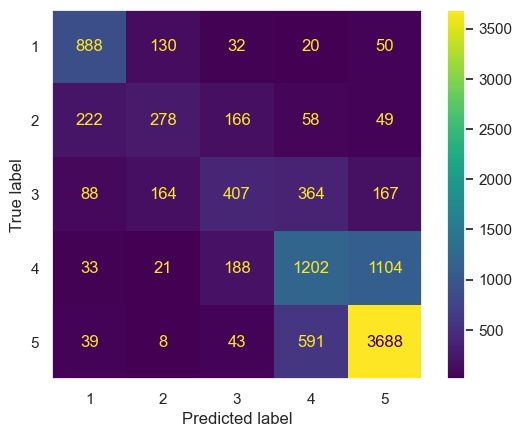

In [50]:
plt.figure()
conf = confusion_matrix(test_stars, predictions_test) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()

You can see that adding the polarity didnt make any significant difference to the accuracy of the model. This is likely because this information is already encapsulated in the word Tfidf vectorization. Next I will try using a few different machine learning models to see if the accuracy can be improved

In [10]:
try:
    print('removed polarization data')
    data = data.drop('polarization', axis=1)
except:
    pass

removed polarization data


In [48]:
class denseTransformer():
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()

In [53]:
# Create preprocessing and training pipeline for each model
pipeline_nb = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('denseTransformer', denseTransformer()), ('classifier', GaussianNB())])
pipeline_gbc = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', GradientBoostingClassifier(random_state=42))])
pipeline_xgb = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))])
pipeline_rfc = Pipeline(steps=[('data_frame', to_data_frame), ('selector', text_selector), ('classifier', RandomForestClassifier(random_state=42))])

# List of pipelines and pipeline names
pipelines = [pipeline_nb, pipeline_gbc, pipeline_xgb, pipeline_rfc]
pipeline_names = ['Naive Bayes', 'Gradient Boosting', 'XGBoost', 'Random Forest Classifier']

In [59]:
%%time
# Convert the data into a DataFrame
X_train_df = to_data_frame.fit_transform(data)
X_test_df = to_data_frame.fit_transform(test_data)
y = np.array(stars) - 1
y_test = np.array(test_stars)
best_accuracy = 0

# Loop to fit each of the pipelines
for pipe, name in zip(pipelines, pipeline_names):
    print('\n', name)
    pipe.fit(X_train_df, y)
    y_pred = pipe.predict(X_test_df)+1
    accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy: ', accuracy)
    if accuracy > best_accuracy:
        best_model = pipe
        best_pred = y_pred
        best_accuracy = accuracy


 Naive Bayes
Test Accuracy:  0.5124

 Gradient Boosting
Test Accuracy:  0.5672

 XGBoost
Test Accuracy:  0.6039

 Random Forest Classifier
Test Accuracy:  0.59
CPU times: user 2h 16min 42s, sys: 1min 48s, total: 2h 18min 31s
Wall time: 1h 31min 39s


<Figure size 640x480 with 0 Axes>

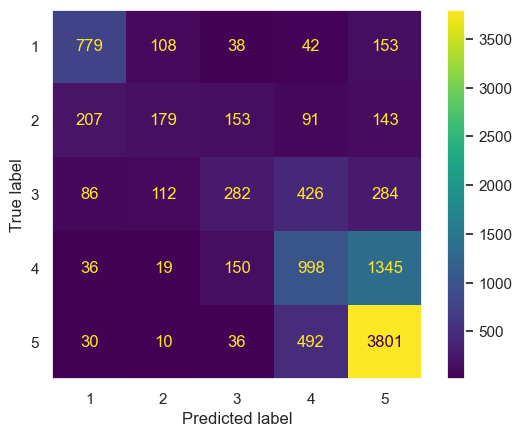

In [60]:
plt.figure()
conf = confusion_matrix(test_stars, best_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.grid(False)
plt.show()

It is clear after running these models that the original logistic regression model yields the best results